# Imports

In [44]:
import os
import os.path as op
import shutil

# standard third party imports
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer

# impute missing values
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import KNNImputer, IterativeImputer, SimpleImputer
from sklearn.tree import DecisionTreeRegressor
from category_encoders import TargetEncoder

In [45]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [46]:
import warnings

warnings.filterwarnings('ignore', message="pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.", 
                        category=FutureWarning)
warnings.filterwarnings('ignore', message="pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.",
                        category=FutureWarning)

In [47]:
# standard code-template imports
from ta_lib.core.api import (
    create_context, get_dataframe, get_feature_names_from_column_transformer, string_cleaning,
    get_package_path, display_as_tabs, save_pipeline, load_pipeline, initialize_environment,
    load_dataset, save_dataset, DEFAULT_ARTIFACTS_PATH
)

import ta_lib.eda.api as eda
from xgboost import XGBRegressor
from ta_lib.regression.api import SKLStatsmodelOLS
from ta_lib.regression.api import RegressionComparison, RegressionReport
import ta_lib.reports.api as reports
from ta_lib.data_processing.api import Outlier

initialize_environment(debug=False, hide_warnings=True)

# Initialisation

In [48]:
artifacts_folder = DEFAULT_ARTIFACTS_PATH

In [49]:
config_path = op.join('conf', 'config.yml')
context = create_context(config_path)

In [50]:
train_X = load_dataset(context, 'train/features')
train_y = load_dataset(context, 'train/target')
print(train_X.shape, train_y.shape)

test_X = load_dataset(context, 'test/features')
test_y = load_dataset(context, 'test/target')
print(test_X.shape, test_y.shape)

(2084, 6) (2084, 1)
(522, 6) (522, 1)


# Feature Engineering 

 - Outlier Treatment
 - Encoding of Categorical Columns
 - Missing Values Imputation

In [51]:
# collecting different types of columns for transformations
cat_columns = train_X.select_dtypes('object').columns
num_columns = train_X.select_dtypes('number').columns

## Outlier Handling

In [52]:
outlier_transformer = Outlier(method='mean')
print(train_X.shape)
train_X = outlier_transformer.fit_transform(train_X)
print(train_X.shape)

(2084, 6)
(2084, 6)


## Encoding

Since there are no categorical columns, no encoding is required

In [53]:
cat_columns

Index([], dtype='object')

In [54]:
tgt_enc_simple_impt = Pipeline([
    ('simple_impute', SimpleImputer(strategy='most_frequent')),
])

features_transformer = ColumnTransformer([
    ## numeric columns
    ('med_enc', SimpleImputer(strategy='median'), num_columns),
    
])


# Feature Analysis

In [55]:
sample_X = train_X.sample(frac=0.1, random_state=context.random_seed)
sample_y = train_y.loc[sample_X.index]

sample_train_X = get_dataframe(
    features_transformer.fit_transform(sample_X, sample_y), 
    get_feature_names_from_column_transformer(features_transformer)
)

# nothing to do for target
sample_train_y = sample_y

In [56]:
train_X = get_dataframe(
    features_transformer.fit_transform(train_X, train_y), 
    get_feature_names_from_column_transformer(features_transformer)
)

## 1. Univariate

In [57]:
train_X.columns

Index(['year', 'week', 'total_post', 'claim_id', 'search_volume',
       'weight_per_unit'],
      dtype='object')

In [58]:
out = eda.get_density_plots(train_X, cols=['total_post', 'search_volume',
                                           'sales_units_value', 'sales_lbs_value'])
out

:DynamicMap   [col]
   :Layout
      .Overlay.I :Overlay
         .Histogram.I    :Histogram   [x]   (Frequency)
         .Distribution.I :Distribution   [total_post]   (Density)
      .Table.I   :Table   [count,mean,std,min,25%,50%,75%,max]

In [59]:
# save the plots are html
reports.feature_analysis(train_X,'./feature_analysis_report.html')

## 2. Bivariate - mutual interactions

In [60]:
out = eda.get_correlation_table(train_X)
out[out["Abs Corr Coef"] > 0.6]

,Variable 1,Variable 2,Corr Coef,Abs Corr Coef


In [61]:
curated_columns = train_X.columns.to_list()

In [62]:
reports.feature_interactions(train_X,'./feature_interaction_report.html')

## 3. Key Drivers - Interaction with Target variable

In [63]:
out = eda.get_target_correlation(train_X, train_y, y_continuous=True)
display_as_tabs([(k, v) for k,v in out.items()])

Tabs
    [0] HoloViews(Bars, name='feature_correlation')

Tabs
    [0] HoloViews(Bars, name='from_model')
    [1] Matplotlib(Figure, name='shap_values')
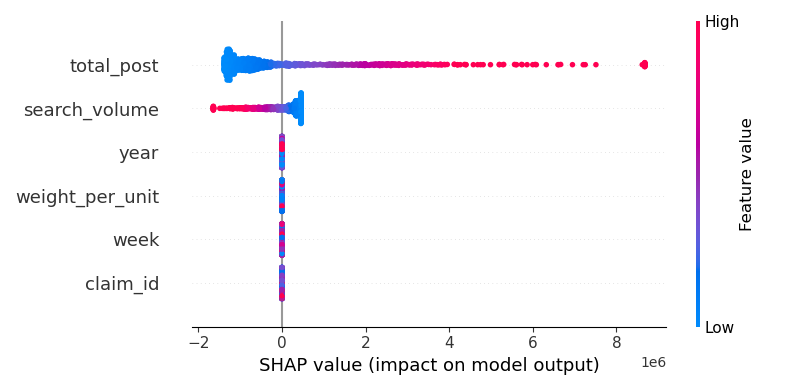

In [64]:
out = eda.get_feature_importances(train_X, train_y, y_continuous=True)
display_as_tabs([(k, v) for k,v in out.items()])

In [65]:
reports.data_exploration(train_X,train_y,'./data_exploration_report.html', y_continuous=True)

In [66]:
reports.key_drivers(train_X,train_y, './key_drivers_report.html', y_continuous=True)

In [67]:
reports.data_exploration(train_X,train_y,'./data_exploration_report.html', y_continuous=True) #final

In [68]:
# saving the list of relevant columns
save_pipeline(curated_columns, op.abspath(op.join(artifacts_folder, 'curated_columns.joblib')))

# save the feature pipeline
save_pipeline(features_transformer, op.abspath(op.join(artifacts_folder, 'features.joblib')))

# Modelling

In [69]:
cols = list(train_X.columns)
vif = eda.calc_vif(train_X)
while max(vif.VIF) > 15:
    #removing the largest variable from VIF
    cols.remove(vif[(vif.VIF==vif.VIF.max())].variables.tolist()[0])
    vif = eda.calc_vif(train_X[cols])

In [70]:
reg_vars = vif.query('VIF < 15').variables
reg_vars = list(reg_vars)

In [71]:
reg_vars

['year', 'week', 'total_post', 'claim_id', 'search_volume', 'weight_per_unit']

## 1. Data Transformation

In [72]:
# Custom Transformations like these can be utilised
def _custom_data_transform(df, cols2keep=None):
    """Transformation to drop some columns in the data
    
    Parameters
    ----------
        df - pd.DataFrame
        cols2keep - columns to keep in the dataframe
    """
    cols2keep = cols2keep or []
    if len(cols2keep):
        return (df
                .select_columns(cols2keep))
    else:
        return df

## 2. Model Pipeline Build

In [73]:
reg_ppln_ols = Pipeline([
    ('',FunctionTransformer(_custom_data_transform, kw_args={'cols2keep':reg_vars})),
    ('estimator', SKLStatsmodelOLS())
])
reg_ppln_ols.fit(train_X, train_y.values.ravel())


Pipeline(steps=[('',
                 FunctionTransformer(func=<function _custom_data_transform at 0x7f2257901430>,
                                     kw_args={'cols2keep': ['year', 'week',
                                                            'total_post',
                                                            'claim_id',
                                                            'search_volume',
                                                            'weight_per_unit']})),
                ('estimator', SKLStatsmodelOLS())])

In [74]:
reg_ppln_ols['estimator'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.229
Model:                            OLS   Adj. R-squared:                  0.227
Method:                 Least Squares   F-statistic:                     103.1
Date:                Thu, 27 Jul 2023   Prob (F-statistic):          7.50e-114
Time:                        19:01:47   Log-Likelihood:                -34270.
No. Observations:                2084   AIC:                         6.855e+04
Df Residuals:                    2077   BIC:                         6.859e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
intercept        2.736e+08   1.37e+08      2.003      0.045    5.68e+06    5.41e+08
year            -1.348e+05   6.77e+04     -1.990      0.047   -2.68e+05   -1983.164
week            -3422.4461   5137.052     -0.666      0.505   -1.35e+04    6651.862
total_post       2119.5638     90.188     23.502      0.000    1942.695    2296.433
claim_id         1315.6898    656.148      2.005      0.045      28.913    2602.467
search_volume     -11.6300      3.180     -3.657      0.000     -17.866      -5.394
weight_per_unit -8.402e+04   1.84e+04     -4.562      0.000    -1.2e+05   -4.79e+04
==============================================================================
Omnibus:                      199.628   Durbin-Watson:                   1.935
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              257.956
Skew:                           0.831   Prob(JB):                     9.68e-57
Kurtosis:                       3.456   Cond. No.                     7.22e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.22e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## 3. Model Evaluation

In [75]:
reg_ppln = Pipeline([
    ('', FunctionTransformer(_custom_data_transform, kw_args={'cols2keep':reg_vars})),
    ('Linear Regression', SKLStatsmodelOLS())
])

test_X = get_dataframe(
    features_transformer.transform(test_X), 
    get_feature_names_from_column_transformer(features_transformer)
)
test_X = test_X[curated_columns]

In [76]:
reg_linear_report = RegressionReport(model=reg_ppln, x_train=train_X, y_train=train_y, x_test= test_X, y_test= test_y, refit=True)
reg_linear_report.get_report(include_shap=False, file_path='regression_linear_model_report')

## 4. Residual Analysis

In [77]:
train_y

,sales_dollars_value
0,53929
1,207827
2,2224116
3,20806
4,5724950
...,...
2079,359022
2080,18163
2081,259271
2082,2497804


In [78]:
threshold=0.3
residual_analysis = test_X.copy()
residual_analysis['prediction'] = reg_ppln_ols.predict(test_X)
residual_analysis['actuals'] = test_y.reset_index(drop = True).iloc[:,0].values
residual_analysis['forecast_flag'] = 'good'
residual_analysis.loc[((residual_analysis['prediction'] > (1+threshold) * residual_analysis['actuals'])\
                       & (residual_analysis['actuals']>100)),'forecast_flag'] = 'over predict'
residual_analysis.loc[((residual_analysis['prediction'] < (1-threshold) * residual_analysis['actuals'])\
                       & (residual_analysis['actuals']>100)),'forecast_flag'] = 'under predict'

In [80]:
# residual_analysis.hvplot.kde(y="sales_dollars_value",by="forecast_flag", ## Grouping by Predictions
#                                 width=800, height=400,
#                                 alpha=0.7,
#                                 ylabel="density",
#                                 xlabel="sales_dollars_value",
#                                 title=f'sales_dollars_value(density)',legend='top_right')

# Modelling - XGB

## Model pipeline build

In [81]:
# let's find features for some decent defaults
estimator = XGBRegressor()
xgb_training_pipe_init = Pipeline([
    ('XGBoost', XGBRegressor())
])
xgb_training_pipe_init.fit(train_X, train_y)

Pipeline(steps=[('XGBoost',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, enable_categorical=False,
                              gamma=0, gpu_id=-1, importance_type=None,
                              interaction_constraints='',
                              learning_rate=0.300000012, max_delta_step=0,
                              max_depth=6, min_child_weight=1, missing=nan,
                              monotone_constraints='()', n_estimators=100,
                              n_jobs=8, num_parallel_tree=1, predictor='auto',
                              random_state=0, reg_alpha=0, reg_lambda=1,
                              scale_pos_weight=1, subsample=1,
                              tree_method='exact', validate_parameters=1,
                              verbosity=None))])

## Model tuning

<AxesSubplot:>

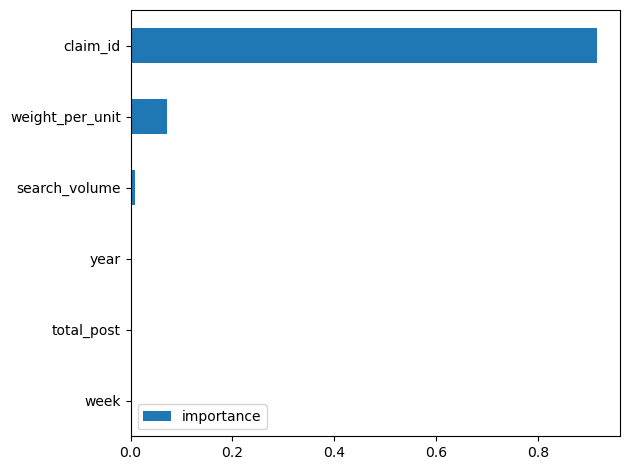

In [82]:
# Understanding the Feature Importance
%matplotlib inline
imp = pd.DataFrame({'importance': xgb_training_pipe_init['XGBoost'].feature_importances_})
imp.index = train_X.columns
imp.sort_values('importance',inplace=True)
imp.plot(kind='barh')

In [83]:
%%time
parameters = {
   'gamma':[0.03],
   'min_child_weight':[6],
   'learning_rate':[0.1],
   'max_depth':[3],
   'n_estimators':[500], 
}
est = XGBRegressor()
xgb_grid = GridSearchCV(est,
                        parameters,
                        cv = 2,
                        n_jobs = 4,
                        verbose=True)

xgb_grid.fit(train_X, train_y)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

Fitting 2 folds for each of 1 candidates, totalling 2 fits


/home/anil_tiger/miniconda3/envs/ta-lib-dev/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/anil_tiger/miniconda3/envs/ta-lib-dev/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/anil_tiger/miniconda3/envs/ta-lib-dev/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/anil_tiger/miniconda3/envs/ta-lib-dev/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning:

0.9898974470024743
{'gamma': 0.03, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 6, 'n_estimators': 500}
CPU times: user 3.43 s, sys: 190 ms, total: 3.62 s
Wall time: 39.9 s


In [84]:
imp_features = curated_columns

In [85]:
xgb_pipeline_final = Pipeline([
    ('', FunctionTransformer(_custom_data_transform, kw_args={'cols2keep':imp_features})),
    ('XGBoost', xgb_grid.best_estimator_)
])
xgb_pipeline_final.fit(train_X, train_y)

Pipeline(steps=[('',
                 FunctionTransformer(func=<function _custom_data_transform at 0x7f2257901430>,
                                     kw_args={'cols2keep': ['year', 'week',
                                                            'total_post',
                                                            'claim_id',
                                                            'search_volume',
                                                            'weight_per_unit']})),
                ('XGBoost',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, enable_categorical=False,
                              gamma=0.03, gpu_id=-1, importance_type=None,
                              interaction_constraints='', learning_rate=0.1,
                              max_delta_step=0, max_depth=3, min_child_weight=6,
                              missing=nan, monotone_constraints='()',
                              n_estimators=500, n_jobs=8, num_parallel_tree=1,
                              predictor='auto', random_state=0, reg_alpha=0,
                              reg_lambda=1, scale_pos_weight=1, subsample=1,
                              tree_method='exact', validate_parameters=1,
                              verbosity=None))])

In [86]:
reg_tree_report = RegressionReport(model=xgb_pipeline_final, x_train=train_X, y_train=train_y, x_test= test_X, y_test= test_y)
reg_tree_report.get_report(include_shap=False, file_path='regression_tree_model_report')